In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy import special
from scipy.special import erf
from scipy import optimize
from datetime import date
from datetime import datetime

In [2]:
# Preprocessing
amd_quotes = pd.read_csv('amd_quotedata.csv', parse_dates=['Expiration Date'], index_col=['Expiration Date'])
amd_calls = amd_quotes.iloc[:,0:11] # Remove puts
ams_calls = amd_calls.drop('2023-04-06', inplace=True) # Remove date before start date

S0 = 92.3
t0 = date(2023, 4, 8)
amd_calls['Strike/Spot'] = amd_calls['Strike']/S0
amd_calls['Mid'] = (amd_calls['Bid']+amd_calls['Ask'])/2
amd_calls


,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
Expiration Date,,,,,,,,,,,,,
2023-04-14,AMD230414C00083000,9.72,-0.105,9.55,9.80,166,0.4442,0.9452,0.0172,293,83.0,0.899242,9.675
2023-04-14,AMD230414C00084000,9.05,0.150,8.65,8.85,22,0.4504,0.9287,0.0217,225,84.0,0.910076,8.750
2023-04-14,AMD230414C00085000,8.10,0.075,7.70,7.90,134,0.4427,0.9068,0.0272,867,85.0,0.920910,7.800
2023-04-14,AMD230414C00086000,7.00,-0.125,6.80,7.00,77,0.4352,0.8782,0.0337,569,86.0,0.931744,6.900
2023-04-14,AMD230414C00087000,6.20,-0.125,5.95,6.15,101,0.4259,0.8417,0.0409,544,87.0,0.942579,6.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-19,AMD251219C00120000,21.43,-0.220,20.95,22.30,23,0.4378,0.5719,0.0060,70,120.0,1.300108,21.625
2025-12-19,AMD251219C00125000,19.20,-1.000,19.85,20.80,5,0.4371,0.5475,0.0061,27,125.0,1.354280,20.325
2025-12-19,AMD251219C00130000,17.55,-1.225,18.50,19.45,10,0.4342,0.5238,0.0061,33,130.0,1.408451,18.975


## First maturity

In [3]:
C1 = amd_calls.loc['2023-04-14']
C1 = C1.reset_index(drop=True)
C1

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
0,AMD230414C00083000,9.72,-0.105,9.55,9.80,166,0.4442,0.9452,0.0172,293,83.0,0.899242,9.675
1,AMD230414C00084000,9.05,0.150,8.65,8.85,22,0.4504,0.9287,0.0217,225,84.0,0.910076,8.750
2,AMD230414C00085000,8.10,0.075,7.70,7.90,134,0.4427,0.9068,0.0272,867,85.0,0.920910,7.800
3,AMD230414C00086000,7.00,-0.125,6.80,7.00,77,0.4352,0.8782,0.0337,569,86.0,0.931744,6.900
4,AMD230414C00087000,6.20,-0.125,5.95,6.15,101,0.4259,0.8417,0.0409,544,87.0,0.942579,6.050
5,AMD230414C00088000,5.50,-0.050,5.15,5.30,192,0.4269,0.7974,0.0483,457,88.0,0.953413,5.225
6,AMD230414C00089000,4.50,-0.300,4.40,4.50,165,0.4155,0.7456,0.0556,934,89.0,0.964247,4.450
7,AMD230414C00090000,3.76,-0.340,3.70,3.80,817,0.4147,0.6869,0.0622,1864,90.0,0.975081,3.750
8,AMD230414C00091000,3.07,-0.380,3.05,3.15,1194,0.4062,0.6223,0.0677,1272,91.0,0.985915,3.100
9,AMD230414C00092000,2.50,-0.365,2.48,2.50,8647,0.4024,0.5529,0.0714,1637,92.0,0.996750,2.490


In [4]:
def iv(p,K,T,r,S0):
    """
    Calculate implied volatility using Black-Scholes formula
    
    Parameters:
    p (float): Market price(s) of the option
    K (float): Strike price(s) of the option
    T (float): Time to expiry of the option, in years
    r (float): Risk-free interest rate, as a decimal
    S0 (float): Current price of the underlying asset
    """
    
    d1 = lambda sigma: (np.log(S0/K) + (r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    d2 = lambda sigma: d1(sigma) - sigma*np.sqrt(T)
    option_price = lambda sigma: S0*norm.cdf(d1(sigma)) - K*np.exp(-r*T)*norm.cdf(d2(sigma))
    option_price_diff = lambda sigma: option_price(sigma) - p
    
    return fsolve(option_price_diff, 0.2*np.ones(len(p)))

In [5]:
# Which risk-free interest rate is used?
#iv_diff = lambda r: np.linalg.norm(iv(np.array(amd_calls_t1['Mid']),np.array(amd_calls_t1['Strike']),6/252,r,S0) - np.array(amd_calls_t1['IV']))
#r_ = minimize(iv_diff, 0.01)
#print(r_)

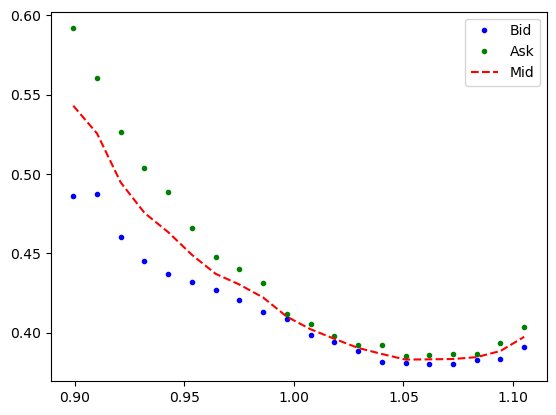

In [6]:
r = 0.01 # TODO: figure out r
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])
K = np.array(C1['Strike'])
numK = len(K)
t1 = 6/252
# Plot data
fig, ax = plt.subplots()
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,t1,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,t1,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,t1,r,S0)), 'r--', label='Mid')
plt.legend()
plt.show()

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35040/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


82.26725329153062


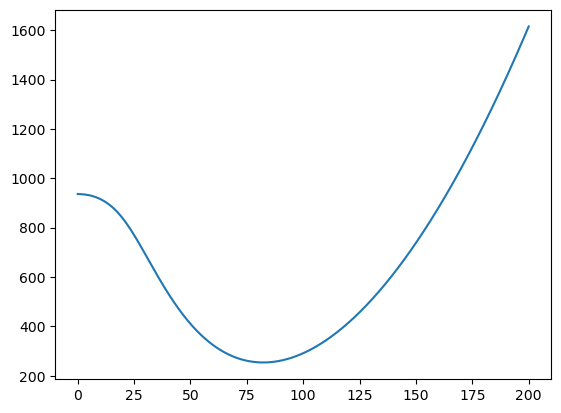

In [7]:
def sigma_objective(sigma,S0,delta_t):
    sqrtt = math.sqrt(delta_t)
    help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)
    B_vec = 0.5*(S0-K)*erf(help_v) + sigma*sqrtt/np.sqrt(2*math.pi)*np.exp(-help_v**2)
    return np.sum((B_vec-mid)**2)


def calculate_sigma0(S0,delta_t):
    res = optimize.minimize_scalar(sigma_objective,args = (S0,delta_t))
    return res.x

sigma0 = calculate_sigma0(S0,6/252)
xx = np.linspace(0,200,1000)
f = lambda x: sigma_objective(x,S0,6/252)
f_ = np.vectorize(f)
plt.plot(xx,f_(xx))
print(sigma0)
P1 = lambda s1: 1
# P1 = lambda s1: 1 if s1 == S0 else 0


#def m_0(s,S0,sigma0,t1): # Joint distribution of S1 and S2
    #return (S0 >= 0) *  (1/(np.sqrt(2*math.pi)*(sigma0*S0))) * np.exp(-1/2*((s-S0)/(sigma0*S0))**2)  *  (1/(np.sqrt(2*math.pi)*sigma0*S0*np.sqrt(t1)) * np.exp(-1/2*((s-S0)/(sigma0*S0*np.sqrt(t1)))**2) )

def m0(s2,s1,delta_t,P1):
    '''
    m0: Joint distribution of (s1,s2)
    P1: Marginal distribution of s1
    '''
    #renormalise m_0 on R^+
    sigma0 = calculate_sigma0(s1,delta_t)
    return norm.pdf(s2,s1,sigma0*np.sqrt(delta_t))/norm.cdf(s1/(sigma0*np.sqrt(delta_t))) * (s1 >= 0) * P1(s1)


def f1(V,omega):
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(numK)
    
    for i in range(numK):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        elif V[i]*omega[i] < delta_C_bid[i]: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f1(V,omega):
    """
    Gradient of g1 with respect to V_K
    """
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    g = np.zeros(numK)
    
    for j in range(numK):
        if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
            g[j] = V[j]*omega[j]
        elif V[j]*omega[j] > delta_C_ask[j]:
            g[j] = delta_C_ask[j]
        elif V[j]*omega[j] < delta_C_bid[j]: 
            g[j] = delta_C_bid[j]
    
    return g
    




In [8]:
S0+3*sigma0

339.1017598745919

In [3]:
def I1(alpha,sigma,s1,K1,K2): 
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return 1/2*np.exp((alpha*sigma)**2/2 + alpha*s1) * (special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2)) )
    
def I2(alpha,sigma,s1,K1,K2):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
    
def I3(alpha,sigma,s1,K1,K2,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return np.exp(alpha*s1) *  (2*sigma*(np.exp(A*alpha*sigma-A**2/2) - np.exp(B*alpha*sigma-B**2/2))  +   np.sqrt(2*np.pi)*np.exp(alpha*alpha*sigma*sigma/2)*(alpha*sigma**2-Q+s1) * (erf((B-alpha*sigma)/np.sqrt(2)) - erf((A-alpha*sigma)/np.sqrt(2))) )

def I4(alpha,sigma,s1,K1,K2,K,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma  
    return 2*sigma* (np.exp(alpha*A*sigma-A*A/2)*(sigma*(alpha*sigma+A) - K - Q + 2*s1) + np.exp(-1/2*B*(B-2*alpha*sigma))*(-sigma*(alpha*sigma+B) + K + Q -2*s1))  +  np.sqrt(2*np.pi)*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/(np.sqrt(2))) - special.erf((A-alpha*sigma)/(np.sqrt(2))) ) * (sigma**2 - (-alpha*sigma**2+K-s1)*(alpha*sigma**2-Q+s1))
    


In [10]:
def I_u_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,delta_t,P1)

def I_u(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_u_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1) )[0]

def I_u_(theta,V,K,s1,K1,K2,delta_t,P1): 
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*s1)
        #print(f'alpha = {alpha}')
        #print(f'sigma = {sigma}')

        if (i == -1): 
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K1,K[0])
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K[i],K[i+1]) # Piecewise integration
        if (i == numK-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI


# Check whether symbolic integration is correct
print(I_u(0,np.zeros(numK),K,S0,0,K[0],6/252,P1))
for i in range(0,numK-1):
    print(I_u(0,np.zeros(numK),K,S0,K[i],K[i+1],6/252,P1))
print(I_u(0,np.zeros(numK),K,S0,K[-1],110,6/252,P1))

print("----")

print(I_u_(0,np.zeros(numK),K,S0,0,110,6/252,P1))
print(I_u(0,np.zeros(numK),K,S0,0,110,6/252,P1))

print("---------")
print(I_u_(np.zeros(4),np.zeros(numK),K,S0,0,110,6/252,P1)) # theta can also be a list


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35040/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


0.23189417511434798
0.024711207977887936
0.026016686496033503
0.02722176343418861
0.028306540260486374
0.029252540638539742
0.030043232272073162
0.03066450677706002
0.031105098149980984
0.03135692250086534
0.03141532474025603
0.03127922170305545
0.03095113556130621
0.03043711608590284
0.029746555104799184
0.02889190110788723
0.02788828611425339
0.026753080423155072
0.025505393536827233
0.02416554124707552
0.1407873715096764
----
0.9183936007554945
0.9183936007556585
---------
[0.9183936 0.9183936 0.9183936 0.9183936]


In [11]:
def I_h_0_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,delta_t,P1)*(s-s1)

def I_h_0(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]

def I_h_0_(theta,V,K,s1,K1,K2,delta_t,P1):
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0
    
    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*S0)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,s1,K1,K[0])
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,s1,K[i],K[i+1]) # Piecewise integration
        if (i == numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,s1,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return P1(s1) * totI

# Check whether symbolic integration is correct
print(I_h_0(0,np.zeros(numK),K,S0,0,K[0],6/252,P1))
for i in range(0,numK-1):
    print(I_h_0(0,np.zeros(numK),K,S0,K[i],K[i+1],6/252,P1))
print(I_h_0(0,np.zeros(numK),K,S0,K[-1],110,6/252,P1))

print("----")

print(I_h_0_(0,np.zeros(numK),K,S0,0,110,6/252,P1))
print(I_h_0(0,np.zeros(numK),K,S0,0,110,6/252,P1))

print("---------")
print(I_h_0_(np.zeros(4),np.zeros(numK),K,S0,0,110,6/252,P1)) # theta can also be a list



def I_h_0_grad_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m0(s,s1,delta_t,P1)*(s-s1)*(s-s1)
    
def I_h_0_grad(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_grad_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]


def I_h_0_hessian_integrand(s,theta,V,K,s1,sigma0,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,sigma0,delta_t,P1)*(s-s1)*(s-s1)*(s-s1)

def I_h_0_hessian(theta,V,K,s1,K1,K2,sigma0,delta_t,P1):
    return integrate.quad(I_h_0_hessian_integrand,K1,K2,args=(theta,V,K,s1,sigma0,delta_t,P1))[0]


-3.872233618827188
-0.21734620096421148


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35040/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


-0.20282523574141822
-0.18501228594141733
-0.16409304877126624
-0.1403395974057791
-0.11410525567106722
-0.08581622581787687
-0.05596022808182871
-0.025072567777474207
0.006279816351738988
0.037515658928093276
0.06805729179355251
0.09734841273727471
0.12487093549423489
0.1501602081003594
0.1728179760709911
0.19252258897252356
0.20903609571929188
0.22220803582426407
1.8662590648912605
----
-1.9157281801156
-1.9157281801159414
---------
[-1.91572818 -1.91572818 -1.91572818 -1.91572818]


In [12]:
def I_Q_integrand(s,h0,V,K,Q,s1,delta_t,P1):
    return math.exp(-np.sum(V*np.maximum(s-K,0))+K.size*h0*(s-S0))*m0(s,s1,delta_t,P1)*np.maximum(s-Q,0)

def I_Q(h0,V,K,Q,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_Q_integrand,K1,K2,args=(h0,V,K,Q,s1,delta_t,P1))[0]

def I_Q_(h0,V,K,Q,s1,K1,K2,delta_t,P1):
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*h0
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(h0*S0)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,Q,K[0],Q) * (K[0] >= Q)
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,max(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        if (i == numK-1):
            if (Q <= K[-1]):
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,K[-1],K2,Q) 
            else:
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,Q,K2,Q) 
            
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece

    return P1(s1) * totI

# Check whether symbolic integration is correct
print(I_Q(0,np.zeros(numK),K,K[0],S0,0,K[0],6/252,P1))
for i in range(0,numK-1):
    print(I_Q(0,np.zeros(numK),K,K[0],S0,K[i],K[i+1],6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[0],S0,K[-1],110,6/252,P1))


print("---------")
print(I_Q_(np.zeros(4),np.zeros(numK),K,K[0],S0,0,110,6/252,P1)) # h0 can also be a list

print("----")
# Check for different Q's
print(I_Q_(0,np.zeros(numK),K,K[0]-10,S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[0]-10,S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[0],S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[0],S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[3],S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[3],S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[-1],S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[-1],S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[-1]+5,S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[-1]+5,S0,0,110,6/252,P1))



/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35040/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


0.0
0.012468033230146263
0.03912994867169328
0.06815011399653668
0.09915777565125697
0.13170903053264046
0.1652968044592132
0.19936368720878123
0.2333171847129944
0.2665468114805733
0.29844233643612
0.32841242076650884
0.35590285251370024
0.380413592336171
0.40151389796886716
0.4188548884037106
0.43217903693354753
0.44132623690786565
0.4462362556117851
0.44694756942206637
3.1755816199312505
---------
[8.3409501 8.3409501 8.3409501 8.3409501]
----
16.164338591971816
16.164338594468763
8.340950097173941
8.340950095702324
6.395552698076312
6.395552698287572
0.5006215612473093
0.5006215612705092
0.05959040871900738
0.05959040817098695


In [13]:
def integrand_G1(s,V,u0,h0,K,omega,S0,delta_t,P1):
    return m0(s,S0,delta_t,P1)*np.exp(-np.sum(V*np.maximum(s-K,0))+(u0-h0*(s-S0))*K.size) 

def G1(V,u0,h0,K,omega,S0,delta_t,P1):
    #expectation = integrate.quad(integrand_G1,0,S0+3*sigma0,args=(V,u0,h0,K,omega,S0,sigma0,t1))[0]
    expectation = I_u_(h0,V,K,S0,S0-50, S0+50,delta_t,P1)*np.exp(-u0) # Gives the same result as the other one! -> Confirms P_sig0 = delta(s-S0)
    #print (f'G1 = {u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation}')
    return u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation

    
def grad_G1(V,u0,h0,K,omega,S0,delta_t,P1):
    """
    Gradient of G_12 with respect to V_K_i
    """
    grad = np.zeros(numK)
    gf1 = grad_f1(V,omega)
    for i in range(numK):
        Q = K[i]
        grad[i] = gf1[i] + mid[i] - I_Q_(h0,V,K,Q,S0,S0-50, S0+50,delta_t,P1)*np.exp(-u0) # Q = K[i] #TODO: can this be sped up by providing Q as a vector?
    
    #print(f'Grad = {grad}')
    #print(f'Grad norm = {np.linalg.norm(grad)}')
    return grad


def Hess_G1(V,u0,h0,K,omega,S0,delta_t,P1):
    '''
    Hessian of G_12
    '''
    H = np.zeros((numK,numK))
    H = np.diag(omega)
    
    for i in range(numK):
        for j in range(numK):
            integrand = lambda s: np.maximum((s-K[i]),0)*np.maximum((s-K[j]),0)*np.exp(-np.sum(V*np.maximum(s-K,0))+(u0-h0*(s-S0))*K.size)*m0(s,S0,sigma0,delta_t,P1)
            H[i,j] += integrate.quad(integrand,S0-50, S0+50)[0] 
    
    return H

    
    

In [15]:
def grad_G1_comparison(V,u0,h0,K,omega,S0,delta_t,P1):
    '''
    Check whether the expression of the gradient is correct, by comparing it to a finite difference approximation
    '''
    grad = grad_G1(V,u0,h0,K,omega,S0,delta_t,P1)
    
    grad_FD = np.zeros(numK)
    eps = 1e-7
    for i in range(numK):
        D = np.zeros(numK)
        D[i] = eps
        grad_FD[i] = (G1(V+D,u0,h0,K,omega,S0,delta_t,P1)-G1(V,u0,h0,K,omega,S0,delta_t,P1))/eps
        
    print(f'Grad = {grad}')
    print(f'Grad_FD = {grad_FD}')

u0, h0, V = 0., 0., [0.]*numK
p0 = np.array([u0] + [h0] + V)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)

grad_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,6/252,P1)




Grad = [-1.33807134 -1.50724963 -1.72679938 -1.92297756 -2.09693072 -2.27467571
 -2.43208215 -2.54485709 -2.63853229 -2.72345447 -2.74977899 -2.72746695
 -2.66628588 -2.56081409 -2.42544838 -2.25441497 -2.07178338 -1.88148266
 -1.68731973 -1.49299907]
Grad_FD = [-1.33806004 -1.50723939 -1.72679013 -1.92296923 -2.09692323 -2.274669
 -2.43207616 -2.54485177 -2.63852756 -2.72345029 -2.74977531 -2.72746372
 -2.66628305 -2.56081163 -2.42544624 -2.25441312 -2.07178178 -1.88148129
 -1.68731855 -1.49299807]


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35040/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


In [16]:
#def Hess_G1_comparison(V,u0,h0,K,omega,S0,sigma0,t1):
    #'''
    #Check whether the expression of the Hessian is correct, by comparing it to a finite difference approximation
    #'''
    #Hess = Hess_G1(V,u0,h0,K,omega,S0,sigma0,t1)
    #u = np.ones(numK)
    #eps = 1e-7
    
    #Hess_u = Hess.dot(u)
    #Hess_u_FD = (grad_G1(V+eps*u,u0,h0,K,omega,S0,sigma0,t1)-grad_G1(V,u0,h0,K,omega,S0,sigma0,t1))/eps
    
    #print(f'Hess_u = {Hess_u}')
    #print(f'Hess_u_FD = {Hess_u_FD}')
    

#Hess_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,sigma0,t1)

In [17]:
u1, h1, V = 0., 0., np.array([0.]*numK)
V_prev = np.array([1] *numK)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)
delta_t = 6/252 #TODO: think about amount of trading days!
P1 = lambda s1: 1

while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
    V_prev = V
    h0 = optimize.root_scalar(I_h_0_,args=(V,K,S0,S0-50, S0+50,delta_t,P1) ,bracket = [-0.02,0.02],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
    #u1 = -math.log(1/(I_u(h1,V,K,s1,sigma_0,t1)))
    print(f' h0 = {h0}')
    u0 = np.log(I_u_(h0,V,K,S0,S0-50, S0+50,delta_t,P1))
    print(f' u0 = {u0}')



    #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
    V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,delta_t,P1), method='Newton-CG', jac= grad_G1, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
    print(f'V = {V}')
    
    print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
    print("----------")

    
    
    

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35040/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


 h0 = -3.469446951953614e-17
 u0 = -8.188198624688682e-05


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35040/2131360636.py:3: RuntimeWarning: overflow encountered in exp
  return 1/2*np.exp((alpha*sigma)**2/2 + alpha*s1) * (special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2)) )
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35040/2131360636.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return 1/2*np.exp((alpha*sigma)**2/2 + alpha*s1) * (special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2)) )
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35040/2131360636.py:11: RuntimeWarning: overflow encountered in exp
  return np.exp(alpha*s1) *  (2*sigma*(np.exp(A*alpha*sigma-A**2/2) - np.exp(B*alpha*sigma-B**2/2))  +   np.sqrt(2*np.pi)*np.exp(alpha*alpha*sigma*sigma/2)*(alpha*sigma**2-Q+s1) * (erf((B-alpha*sigma)/np.sqrt(2)) - erf((A-alpha*sigma)/np.sqrt(2))) )
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35040/2131360636.py:

V = [ 0.05823278 -0.21401164  0.0075072   0.04413563 -0.04835566  0.02945114
  0.09946556 -0.03767539 -0.08898365  0.09868833  0.0851061   0.02504431
  0.02841295  0.01047968  0.06101928  0.02306465  0.04263926  0.06112
  0.03511015 -0.05911544]
normdiff = inf
----------
 h0 = 0.0020326492218240267
 u0 = 0.12669685142456702
V = [-0.03896598 -0.29598091  0.05567292  0.13184173  0.01032435  0.08994446
  0.1515105  -0.0600033  -0.15114846  0.08717766  0.07315219  0.01160796
  0.03629218  0.02335892  0.08989049  0.03029994  0.04637755  0.06424112
  0.02663517 -0.09700371]
normdiff = 0.6381772718500308
----------
 h0 = 0.002888000215614808
 u0 = 0.18065699767466142
V = [-0.04593772 -0.30188495  0.0555996   0.13360224  0.01140919  0.09237431
  0.15552055 -0.05706463 -0.14821554  0.09304637  0.07857363  0.01556608
  0.03932545  0.02478644  0.09069872  0.02942346  0.04515916  0.06313612
  0.02529234 -0.09947562]
normdiff = 0.03327102507742519
----------
 h0 = 0.0031453177198871684
 u0 = 0.1927

In [18]:
c = np.zeros(numK)
for i in range(numK):
    c[i] = I_Q_(h0,V,K,K[i],S0,50,120,delta_t,P1)*np.exp(-u0)
    print(f'K={K[i]}, C = {c[i]}')

K=83.0, C = 9.66198408815015
K=84.0, C = 8.73496917849266
K=85.0, C = 7.8214182431851995
K=86.0, C = 6.92833168076906
K=87.0, C = 6.065461457081919
K=88.0, C = 5.242709927718861
K=89.0, C = 4.470547876648995
K=90.0, C = 3.7562052158242913
K=91.0, C = 3.100697744525634
K=92.0, C = 2.5069197902113904
K=93.0, C = 1.9836165060413038
K=94.0, C = 1.5359963367343108
K=95.0, C = 1.1635082057459407
K=96.0, C = 0.8628284923295131
K=97.0, C = 0.6280801015872904
K=98.0, C = 0.4512722075404316
K=99.0, C = 0.32170879432501265
K=100.0, C = 0.22887196709211666
K=101.0, C = 0.16321334797321932
K=102.0, C = 0.1165156397424964


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35040/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


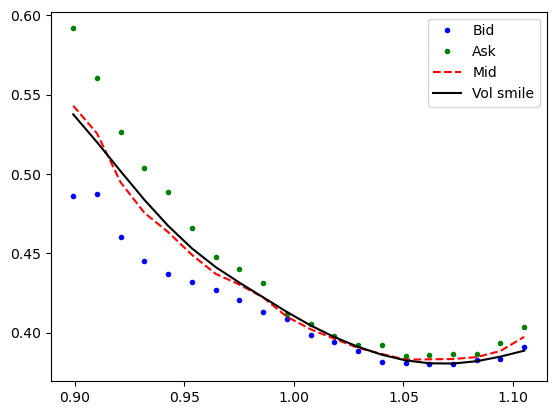

In [19]:
# Plot data
fig, ax = plt.subplots()
T_ = 6/252
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,T_,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,T_,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,T_,r,S0)), 'r--', label='Mid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(c,K,T_,r,S0)), 'k', label='Vol smile')
plt.legend()
plt.show()

## Other maturities

In [4]:
def sigma_objective_(p,C,delta_t,X1,P_disc_X1):
    '''
    C: Pandas dataframe containing all info of that volatility slice (fixed maturity)
    '''
    mid = np.array(C['Mid'])
    K = np.array(C['Strike'])
    sigma0, beta = p[0], p[1]
    sqrtt = math.sqrt(delta_t)
    sigma = lambda s: sigma0*s**beta
    tot = 0
    
    for i in range(K.size): 
        k = K[i]
        help_v = lambda s: (k-s)/(np.sqrt(2)*sqrtt*sigma(s))
        B_vec = lambda s: 0.5*(s-k)*erf(help_v(s)) + sigma(s)*sqrtt/np.sqrt(2*math.pi)*np.exp(-help_v(s)**2)
        B_vec_ = np.vectorize(B_vec)
        expectation_k = np.sum(B_vec_(X1)*P_disc_X1)
        tot += (expectation_k - mid[i])**2 #TODO: compare these two, to check for good fit
        
    #print(f'tot = {tot}')
    return tot


def calculate_sigma0_beta(C,delta_t,X1,P_disc_X1):
    res = optimize.minimize(sigma_objective_,x0 = np.array([0.1, 1]), args = (C,delta_t,X1,P_disc_X1), method='nelder-mead',options={'maxfev': 3000}) # Slow convergence 
    #print(res)
    return res.x

def calculate_sigma(C,delta_t,X1,P_disc_X1):
    sigma0, beta = calculate_sigma0_beta(C,delta_t,X1,P_disc_X1)
    return sigma0*X1**beta


def m0(s2,X1,K,sigma_sqrtdt,P_disc_X1):
    '''
    m0: Joint distribution of (s1,s2)
    X1: Grid of s1's
    P_disc_X1: Discrete marginal distribution of s1
    '''
    #renormalise m_0 on R^+
    return norm.pdf(s2,X1,sigma_sqrtdt)/norm.cdf(X1/(sigma_sqrtdt)) * (X1 >= 0) * P_disc_X1 #TODO: Check whether normalized


def f1(V,omega, C):
    ask = np.array(C['Ask'])
    bid = np.array(C['Bid'])
    mid = np.array(C['Mid'])
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(mid.size)
    
    for i in range(mid.size):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        elif V[i]*omega[i] < delta_C_bid[i]: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f1(V,omega, C):
    """
    Gradient of g1 with respect to V_K
    """
    ask = np.array(C['Ask'])
    bid = np.array(C['Bid'])
    mid = np.array(C['Mid'])
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    g = np.zeros(mid.size)
    
    for j in range(mid.size):
        if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
            g[j] = V[j]*omega[j]
        elif V[j]*omega[j] > delta_C_ask[j]:
            g[j] = delta_C_ask[j]
        elif V[j]*omega[j] < delta_C_bid[j]: 
            g[j] = delta_C_bid[j]
    
    return g



0.1115268199650567
1.4593146628808138
82.26724938987708
[0.00000000e+000 0.00000000e+000 0.00000000e+000 3.32915966e-204
 5.01965236e-034 1.25342387e-007 1.86805800e-003 5.42727054e-003
 3.25107741e-003 1.25373899e-003 3.71492860e-004 8.66118900e-005
 1.55328127e-005 2.08343383e-006 2.05578827e-007]


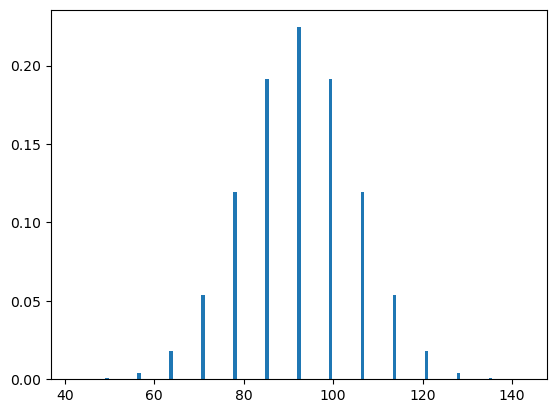

In [5]:
maturities = amd_calls.index.unique()
T0 = maturities[0]
C0 = amd_calls.loc[T0]
C0 = C0.reset_index(drop=True)
T1 = maturities[1]
C1 = amd_calls.loc[T1]
C1 = C1.reset_index(drop=True)
K = np.array(C1['Strike'])
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])

a, b, n = S0-50, S0+50, 15 # Take odd n, such that X1[(n-1)/2] = S0
K1, K2 = a, b
X1 = np.linspace(a,b,n) # Discrete grid

t0 = date(2023, 4, 8)
t1 = maturities[0].to_pydatetime().date()
delta = t1 - t0
delta = delta.days
deltat = delta/252
P1_ = lambda s1: norm.pdf(s1, S0, calculate_sigma(C0,6/252,[S0],[1])*np.sqrt(6/252)) # Marginal distribution of S at t1
P1_disc = lambda x: P1_(x)/sum(P1_(X1))
xx = np.linspace(0,200,1000)
P1_disc_ = np.vectorize(P1_disc)
plt.bar(X1,P1_disc(X1))



u_list, h_list = np.zeros(n), np.zeros(n)
V0 = np.zeros(K.size)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)

# Test for S at t0
sigma0, beta = calculate_sigma0_beta(C0,6/252,[S0],[1])
print(sigma0)
print(beta)
print(sigma0*S0**beta) # Gives same value (82.267) -> OK

# Test for S at t1
#sigma0, beta = calculate_sigma0_beta(C1,7/365,X1,P1_disc(X1))
#print(sigma0)
#print(beta)
#print(sigma0*X1**beta)


# 
sigma = calculate_sigma(C1,7/365,X1,P1_disc(X1))
sigma_sqrtdt = sigma*np.sqrt(7/365)
print(m0(100,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1)))


In [6]:
def I_u_integrand(s2,theta,V,s1,K,sigma_sqrtdt,P_disc_X1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))+K.size*theta*(s2-s1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_X1)

def I_u(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    Iu = np.zeros(X1.size)
    for i in range(X1.size): 
        Iu[i] = integrate.quad(I_u_integrand,K1,K2,args=(theta[i],V,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i]))[0]
    return Iu


def I_u_(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2): 
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0

    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) + K.size*theta
        gamma = sum(V[:i+1]*K[:i+1]) - K.size*(theta*X1)

        if (i == -1): 
            newPiece = np.exp(gamma) * I1(alpha,sigma_sqrtdt,X1,K1,K[0])
        if (i >= 0 and i < K.size-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma_sqrtdt,X1,K[i],K[i+1]) # Piecewise integration
        if (i == K.size-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma_sqrtdt,X1,K[-1],K2)
        
        newPiece *= P_disc_X1
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI 

K = np.array(C1['Strike'])
sigma_sqrtdt = calculate_sigma(C1,6/252,X1,P1_disc(X1))*np.sqrt(6/252) #TODO: investigate why this one takes so long compared to I_h and I_Q
#print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,K[0]))
#for i in range(0,numK-1):
    #print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),K[i],K[i+1]))
#print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),K[-1],110))

print("-----------")
#print(I_u_integrand(100,h_list,V0,X1,K,sigma_sqrtdt,P1_disc(X1)))
print(I_u_(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110)) 
print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110))
# I attribute the differences on the boundaries due to inaccuracy in the integral aproximation?


# Test for S at t0
X0 = np.array([S0])
#P0 = lambda s: 1 if s == S0 else 0
P0_disc = np.array([1.])
sigma_sqrtdt0 = calculate_sigma(C0,6/252,X0,P0_disc)*np.sqrt(6/252)
print(I_u_(np.zeros(1),V0,X0,np.array(C0['Strike']),sigma_sqrtdt0,P0_disc,0,110))

-----------
[9.60010661e-05 7.51742360e-04 4.28899342e-03 1.78293343e-02
 5.40018034e-02 1.19172154e-01 1.91369560e-01 2.00625442e-01
 1.29049431e-01 6.36411211e-02 2.42609740e-02 6.53804253e-03
 1.21706583e-03 1.59536599e-04 1.50260834e-05]
[0.00000000e+00 7.51742360e-04 4.28899342e-03 1.78293343e-02
 5.40018034e-02 1.19172154e-01 1.91369560e-01 2.00625442e-01
 1.29050908e-01 6.37841124e-02 2.48870066e-02 7.13715949e-03
 1.45020395e-03 2.08290417e-04 2.13057324e-05]
[0.91839361]


In [37]:
def I_h_0_integrand(s2,theta,V,s1,K,sigma_sqrtdt,P_disc_X1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))+K.size*theta*(s2-s1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_X1)*(s2-s1)

def I_h_0(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    Ih = np.zeros(X1.size)
    for i in range(X1.size): 
        Ih[i] = integrate.quad(I_h_0_integrand,K1,K2,args=(theta[i],V,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i]))[0]
    return Ih

def I_h_0_(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    print(f'theta = {theta}')
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0
    
    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) + K.size*theta
        gamma = sum(V[:i+1]*K[:i+1]) - K.size*(theta*X1)
        #print(f'alpha = {alpha}')
        #print(f'sigma = {sigma}')
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K1,K[0])
        if (i >= 0 and i < K.size-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K[i],K[i+1]) # Piecewise integration
        if (i == K.size-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    print (f'i_h_0_ = {totI * P_disc_X1}')
    return totI * P_disc_X1



print(I_h_0_(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110)) 
print(I_h_0(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110))

# Test for S at t0
X0 = np.array([S0])
P0_disc = np.array([1.])
sigma_sqrtdt0 = calculate_sigma(C0,6/252,X0,P0_disc)*np.sqrt(6/252)
print(I_h_0_(np.zeros(1),V0,X0,np.array(C0['Strike']),sigma_sqrtdt0,P0_disc,0,110))




#TODO: implement multidimensional or not? -> yes: is Jacobian!
def I_h_0_grad_integrand(s2,theta,V,s1,K,sigma_sqrtdt,P_disc_X1): 
    # Is derivative wrt theta!
    return np.exp(-np.sum(V*np.maximum(s2-K,0))+K.size*theta*(s2-s1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_X1)*(s2-s1)*(s2-s1)
    
def I_h_0_grad(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    Ih_grad = np.zeros((X1.size,V.size))
    if X1.size == 1: 
        Ih_grad = integrate.quad(I_h_0_grad_integrand,K1,K2,args=(theta,V,X1,K,sigma_sqrtdt,P_disc_X1))[0]
    else:
        for i in range(X1.size):
            Ih_grad[i] = integrate.quad(I_h_0_grad_integrand,K1,K2,args=(theta[i],V,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i]))[0]
    return Ih_grad

# implement multimensional?
def I_h_0_hessian_integrand(s2,theta,V,s1,K,sigma_sqrtdt,P_disc_X1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))+K.size*theta*(s2-s1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_X1)*(s2-s1)*(s2-s1)*(s2-s1)

def I_h_0_hessian(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    return integrate.quad(I_h_0_hessian_integrand,K1,K2,args=(theta,V,X1,K,sigma_sqrtdt,P_disc_X1))[0]



theta = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
i_h_0_ = [-0.09448    -0.09940636 -0.1043393  -0.10926351 -0.1141637  -0.1190248
 -0.12383199 -0.12857085 -0.1332274  -0.13778821 -0.14224048 -0.14657205
 -0.15077153 -0.1548283  -0.15873254 -0.16247529 -0.16604845 -0.16944476
 -0.17265789 -0.17568234 -0.17851348 -0.18114753 -0.18358154 -0.18581335
 -0.18784158 -0.18966556 -0.19128535 -0.19270166 -0.19391583 -0.19492978
 -0.19574598 -0.19636739 -0.19679745 -0.19704001 -0.19709932 -0.19697993
 -0.19668675 -0.19622493 -0.19559985 -0.19481711 -0.19388247 -0.19280182
 -0.19158118 -0.19022663 -0.18874434 -0.18714048 -0.18542125 -0.18359286
 -0.18166147 -0.1796332  -0.17751413 -0.17531024 -0.17302745 -0.17067156
 -0.1682483  -0.16576323 -0.16322183 -0.16062943 -0.15799121 -0.15531224
 -0.15

In [8]:
def I_Q_integrand(s2,h_list,V,X1,K,Q,sigma_sqrtdt,P_disc_X1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))+K.size*h_list*(s2-X1))*m0(s2,X1,K,sigma_sqrtdt,P_disc_X1)*np.maximum(s2-Q,0)

def I_Q(h_list,V,X1,K,Q,sigma_sqrtdt,P_disc_X1,K1,K2):
    Iq = np.zeros(X1.size)
    for i in range(X1.size): 
        Iq[i] = integrate.quad(I_Q_integrand,K1,K2,args=(h_list[i],V,X1[i],K,Q,sigma_sqrtdt[i],P_disc_X1[i]))[0]
    return Iq

def I_Q_(h_list,V,X1,K,Q,sigma_sqrtdt,P_disc_X1,K1,K2):
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0

    for i in range(-1,K.size): 
        alpha = -sum(V[:i+1]) + K.size*h_list
        gamma = sum(V[:i+1]*K[:i+1]) - K.size*(h_list*X1)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,Q,K[0],Q) * (K[0] >= Q)
        if (i >= 0 and i < K.size-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,max(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        if (i == K.size-1):
            if (Q <= K[-1]):
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,K[-1],K2,Q) 
            else:
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,Q,K2,Q) 
            
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece

    return totI * P_disc_X1


K = np.array(C1['Strike'])
print(I_Q_(h_list,V0,X1,np.array(C1['Strike']),K[0],sigma_sqrtdt,P1_disc(X1),0,110))
print(I_Q(h_list,V0,X1,np.array(C1['Strike']),K[0],sigma_sqrtdt,P1_disc(X1),0,110))

# Test for S at t0
X0 = np.array([S0])
P0_disc = np.array([1.])
sigma_sqrtdt0 = calculate_sigma(C0,6/252,X0,P0_disc)*np.sqrt(6/252)
print(I_Q_(np.zeros(1),V0,X0,K,K[0],sigma_sqrtdt0,P0_disc,0,110))

[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.63698191e-62
 4.47292021e-09 3.79011815e-02 8.51131195e-01 1.77227759e+00
 1.14207432e+00 4.50731505e-01 1.31205326e-01 2.87578774e-02
 4.71974796e-03 5.76690545e-04 5.22749952e-05]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.44080055e-85
 5.04067043e-11 3.79011811e-02 8.51131195e-01 1.77227759e+00
 1.14208739e+00 4.51744225e-01 1.34590961e-01 3.13931206e-02
 5.62385152e-03 7.52924674e-04 7.41233918e-05]
[8.34095027]


In [9]:
def G1_(V,u_list,h_list,X1,C,omega,sigma_sqrtdt,P_disc_X1,K1,K2):
    K = np.array(C['Strike'])
    Iu = I_u_(h_list,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2)
    expectation = np.sum(Iu*np.exp(-u_list)*P_disc_X1)
    return np.sum(u_list*P_disc_X1) + np.sum(V*mid) + np.sum(f1(V,omega,C)) + expectation

    
def grad_G1_(V,u_list,h_list,X1,C,omega,sigma_sqrtdt,P_disc_X1,K1,K2):
    """
    Gradient of G_12 with respect to V_K_i
    """
    K = np.array(C['Strike'])
    mid = np.array(C['Mid'])
    grad = np.zeros(K.size)
    gf1 = grad_f1(V,omega,C)
    for i in range(K.size):
        Q = K[i]
        grad[i] = gf1[i] + mid[i] - np.sum(I_Q_(h_list,V,X1,K,Q,sigma_sqrtdt,P_disc_X1,K1,K2)*np.exp(-u_list)*P_disc_X1) # Q = K[i] #TODO: can this be sped up by providing Q as a vector?

    #print(f'Grad = {grad}')
    #print(f'Grad norm = {np.linalg.norm(grad)}')
    return grad

In [10]:
print(G1_(V0,u_list,h_list,X1,C1,omega_K,sigma_sqrtdt,P1_disc(X1),K1,K2))
print(grad_G1_(V0,u_list,h_list,X1,C1,omega_K,sigma_sqrtdt,P1_disc(X1),K1,K2))

0.15272992980263386
[-1.65352952  7.71679194  6.9329889   6.19512133  5.47825633  4.80746639
  4.15783014  3.57943421  2.99737503  2.48675975  2.02770601  1.61534058
  1.24979717  0.94621382  0.68473024  0.46048531  0.28861508  0.14925118
  0.0475198  -0.03145887]


In [11]:
maturities = amd_calls.index.unique()
maturities

DatetimeIndex(['2023-04-14', '2023-04-21', '2023-04-28', '2023-05-05',
               '2023-05-12', '2023-05-19', '2023-05-26', '2023-06-16',
               '2023-07-21', '2023-09-15', '2023-10-20', '2024-01-19',
               '2024-06-21', '2025-01-17', '2025-12-19'],
              dtype='datetime64[ns]', name='Expiration Date', freq=None)

[82.50554971]
[0.01036219 0.01050254 0.01064109 0.01077772 0.0109123  0.01104472
 0.01117486 0.01130259 0.01142781 0.0115504  0.01167023 0.01178721
 0.01190122 0.01201215 0.01211989 0.01222434 0.01232541 0.01242299
 0.01251698 0.01260729 0.01269384 0.01277653 0.01285529 0.01293004
 0.01300069 0.01306718 0.01312944 0.0131874  0.01324102 0.01329022
 0.01333497 0.01337521 0.0134109  0.01344201 0.01346851 0.01349036
 0.01350755 0.01352005 0.01352785 0.01353095 0.01352934 0.01352302
 0.013512   0.01349629 0.01347591 0.01345088 0.01342123 0.01338697
 0.01334817 0.01330484 0.01325704 0.01320481 0.01314821 0.0130873
 0.01302214 0.01295279 0.01287933 0.01280183 0.01272037 0.01263503
 0.0125459  0.01245306 0.0123566  0.01225663 0.01215324 0.01204652
 0.01193658 0.01182354 0.01170749 0.01158854 0.01146681 0.01134241
 0.01121546 0.01108607 0.01095436 0.01082045 0.01068445 0.0105465
 0.0104067  0.01026518 0.01012206]


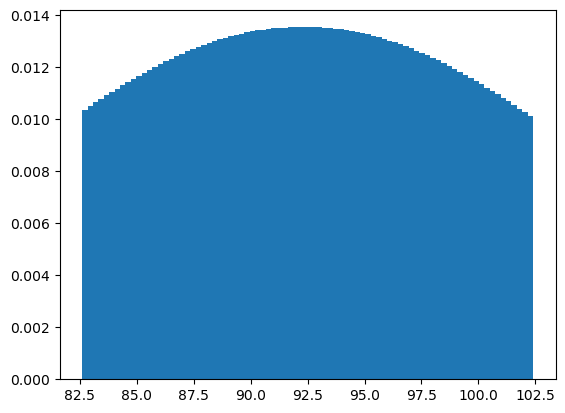

In [24]:
# Try to fit the multi-period case to the first period
T0 = maturities[0]
C0 = amd_calls.loc[T0]
C0 = C1.reset_index(drop=True)
T1 = maturities[1]
C1 = amd_calls.loc[T1]
C1 = C1.reset_index(drop=True)

r = 0.01 # TODO: figure out r
K = np.array(C1['Strike'])
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])
#K1, K2, n = S0-30, S0+30, 81 # Take odd n, such that X1[(n-1)/2] = S0
K1, K2, n = K[0], K[-1], 81 # Take odd n, such that X1[(n-1)/2] = S0
X1 = np.linspace(K1,K2,n) # Discrete grid
u_list,h_list = np.zeros(n), np.zeros(n)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)
delta_t = 6/252
S0 = 92.3

#P1 = lambda s1: (s1 == S0)
#P1_disc = lambda x: P1(x)/sum(P1(X1))
#xx = np.linspace(0,200,1000)
#P1_disc_ = np.vectorize(P1_disc)
#plt.bar(X1,P1_disc_(X1))
#P_disc_X1 = np.zeros(n)
#P_disc_X1[int((n-1)/2)] = 1
#print(P1_disc_X1)
sigma_prev = calculate_sigma(C0,6/252,[S0],[1]) # sigma of previous marginal is used!!!
print(sigma_prev)
P1 = lambda s1: norm.pdf(s1, S0, sigma_prev*np.sqrt(delta_t)) # Marginal distribution of S at t1, 
P1_disc = lambda x: P1(x)/sum(P1(X1))
P1_disc_ = np.vectorize(P1_disc)
plt.bar(X1,P1_disc_(X1))
P_disc_X1 = P1_disc(X1)
print(P_disc_X1)

In [41]:
u0, h0, V0 = 0., 0., np.array([0.]*K.size)
V_prev = np.array([1] *K.size)
sigma_sqrtdt = calculate_sigma(C1,delta_t,X1,P_disc_X1)


#while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
V_prev = V0
for i in range(n):
    #h0 = optimize.root_scalar(I_h_0_, args=(V0,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i],K1,K2), bracket=[-0.01,0.01], x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
    h0 = optimize.newton(I_h_0_, x0 = 0, args=(V0,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i],K1,K2), fprime = I_h_0_grad, fprime2 = I_h_0_hessian).x
    #h0 = optimize.minimize(I_h_0_,x0 = np.array([-0.01, 0.01]), args = (V0,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i],K1,K2), method='nelder-mead',options={'maxfev': 3000}).x # Slow convergence 
    print(f' h0 = {h0}')
    u0 = -np.log(P_disc_X1[i]/I_u_(h0,V0,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i],K1,K2))
    print(f' u0 = {u0}')



    #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
    #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,delta_t,P1), method='Newton-CG', jac= grad_G1, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
    #print(f'V = {V}')
    
    #print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
    #print("----------")




theta = [-0.01  0.01]
i_h_0_ = [0.00263199 0.34618059]


ValueError: The user-provided objective function must return a scalar value.

theta = -0.1
i_h_0_ = nan
theta = -0.1
i_h_0_ = nan
theta = -0.0997997997997998
i_h_0_ = nan
theta = -0.0995995995995996
i_h_0_ = nan
theta = -0.0993993993993994
i_h_0_ = nan
theta = -0.0991991991991992
i_h_0_ = nan
theta = -0.098998998998999
i_h_0_ = nan
theta = -0.0987987987987988
i_h_0_ = nan
theta = -0.09859859859859861
i_h_0_ = nan
theta = -0.09839839839839841
i_h_0_ = nan
theta = -0.09819819819819821
i_h_0_ = nan
theta = -0.09799799799799801
i_h_0_ = nan
theta = -0.0977977977977978
i_h_0_ = nan
theta = -0.0975975975975976
i_h_0_ = nan
theta = -0.0973973973973974
i_h_0_ = nan
theta = -0.0971971971971972
i_h_0_ = nan
theta = -0.096996996996997
i_h_0_ = nan
theta = -0.0967967967967968
i_h_0_ = nan
theta = -0.0965965965965966
i_h_0_ = nan
theta = -0.0963963963963964
i_h_0_ = nan
theta = -0.0961961961961962
i_h_0_ = nan
theta = -0.09599599599599601
i_h_0_ = nan
theta = -0.09579579579579581
i_h_0_ = nan
theta = -0.0955955955955956
i_h_0_ = nan
theta = -0.0953953953953954
i_h_0_ = nan
t

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35686/2131360636.py:7: RuntimeWarning: overflow encountered in exp
  return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35686/2131360636.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_35686/2131360636.py:7: RuntimeWarning: overflow encountered in double_scalars
  return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2))

i_h_0_ = 0.1394602962293372
theta = -0.042942942942942944
i_h_0_ = 0.13946029551574565
theta = -0.04274274274274274
i_h_0_ = 0.1394602947457486
theta = -0.04254254254254255
i_h_0_ = 0.1394602939148873
theta = -0.04234234234234235
i_h_0_ = 0.13946029301835083
theta = -0.042142142142142146
i_h_0_ = 0.13946029205095
theta = -0.041941941941941945
i_h_0_ = 0.1394602910070771
theta = -0.04174174174174174
i_h_0_ = 0.1394602898806919
theta = -0.04154154154154154
i_h_0_ = 0.139460288665276
theta = -0.04134134134134134
i_h_0_ = 0.1394602873537858
theta = -0.041141141141141147
i_h_0_ = 0.1394602859386293
theta = -0.040940940940940945
i_h_0_ = 0.13946028441161235
theta = -0.040740740740740744
i_h_0_ = 0.13946028276389275
theta = -0.04054054054054054
i_h_0_ = 0.13946028098592772
theta = -0.04034034034034034
i_h_0_ = 0.13946027906742833
theta = -0.04014014014014014
i_h_0_ = 0.1394602769972795
theta = -0.039939939939939946
i_h_0_ = 0.1394602747634965
theta = -0.039739739739739745
i_h_0_ = 0.139460272

i_h_0_ = -157.54807089632644
theta = 0.01911911911911912
i_h_0_ = -170.01242826816033
theta = 0.019319319319319322
i_h_0_ = -183.46202653703165
theta = 0.019519519519519524
i_h_0_ = -197.97474373517656
theta = 0.019719719719719725
i_h_0_ = -213.6346137374502
theta = 0.019919919919919926
i_h_0_ = -230.53231284781938
theta = 0.020120120120120114
i_h_0_ = -248.76568484790536
theta = 0.020320320320320315
i_h_0_ = -268.44030754785297
theta = 0.020520520520520516
i_h_0_ = -289.6701041199459
theta = 0.020720720720720717
i_h_0_ = -312.5780027549573
theta = 0.02092092092092092
i_h_0_ = -337.296648460766
theta = 0.02112112112112112
i_h_0_ = -363.9691711248676
theta = 0.02132132132132132
i_h_0_ = -392.7500142881264
theta = 0.021521521521521522
i_h_0_ = -423.80582942866084
theta = 0.021721721721721723
i_h_0_ = -457.31644093410205
theta = 0.021921921921921925
i_h_0_ = -493.4758873497664
theta = 0.022122122122122126
i_h_0_ = -532.4935449318914
theta = 0.022322322322322327
i_h_0_ = -574.5953400118224

i_h_0_ = nan
theta = 0.0845845845845846
i_h_0_ = nan
theta = 0.0847847847847848
i_h_0_ = nan
theta = 0.084984984984985
i_h_0_ = nan
theta = 0.0851851851851852
i_h_0_ = nan
theta = 0.0853853853853854
i_h_0_ = nan
theta = 0.0855855855855856
i_h_0_ = nan
theta = 0.0857857857857858
i_h_0_ = nan
theta = 0.085985985985986
i_h_0_ = nan
theta = 0.08618618618618618
i_h_0_ = nan
theta = 0.08638638638638638
i_h_0_ = nan
theta = 0.08658658658658658
i_h_0_ = nan
theta = 0.08678678678678678
i_h_0_ = nan
theta = 0.08698698698698698
i_h_0_ = nan
theta = 0.08718718718718718
i_h_0_ = nan
theta = 0.08738738738738738
i_h_0_ = nan
theta = 0.08758758758758758
i_h_0_ = nan
theta = 0.08778778778778779
i_h_0_ = nan
theta = 0.08798798798798799
i_h_0_ = nan
theta = 0.08818818818818819
i_h_0_ = nan
theta = 0.08838838838838839
i_h_0_ = nan
theta = 0.08858858858858859
i_h_0_ = nan
theta = 0.08878878878878879
i_h_0_ = nan
theta = 0.08898898898898899
i_h_0_ = nan
theta = 0.0891891891891892
i_h_0_ = nan
theta = 0.0893

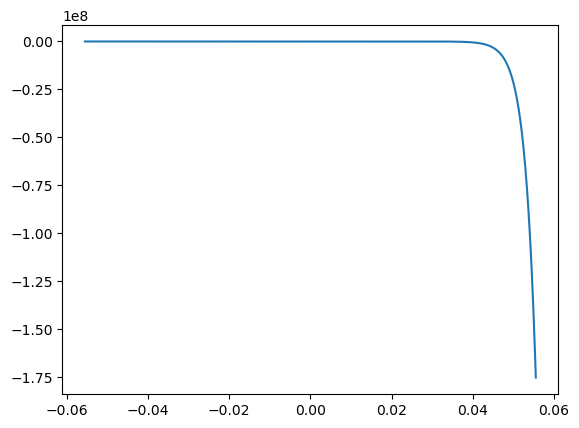

In [40]:
tt = np.linspace(-1e-1,1e-1,1000)
i = 0
Ih0 = lambda tt: I_h_0_(tt,V0,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i],K1,K2)
Ih0_ = np.vectorize(Ih0)
plt.plot(tt,Ih0_(tt))

In [ ]:
for T1 in maturities[1:2]:
    C1 = amd_calls.loc[T1]
    C1 = C1.reset_index(drop=True)
    
    r = 0.01 # TODO: figure out r
    ask = np.array(C1['Ask'])
    bid = np.array(C1['Bid'])
    mid = np.array(C1['Mid'])
    K = np.array(C1['Strike'])

    
    u_list = np.zeros(n)
    h_list = np.zeros(n)
    
    while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
        for i in range(n): 
            s1 = X1[i]
            V_prev = V
            h0 = optimize.root_scalar(I_h_0_,args=(V,K,s1,50,120,delta_t,P1) ,bracket = [-0.02,0.02],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
            h_list[i] = h0
            u0 = np.log(I_u_(h0,V,K,s1,50,120,delta_t,P1))
            u_list[i] = u[0]

        print(f'h_list = {h_list}')
        print(f'u_list = {u_list}')
        #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
        V = optimize.minimize(fun= G1_, x0=V, args=(u_list,h_list,K,omega_K,s1,delta_t,P1_,P1_disc(X1)), method='Newton-CG', jac= grad_G1_, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
        print(f'V = {V}')

        print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
        print("----------")

    
    
    
    # Compute next marginal probability (S at t2)
    P1 = lambda x:(1/(np.sqrt(2*math.pi)*1e-1)) * np.exp(-1/2*((x-S0)/1e-1)**2) * (x >= 0) # Approximation of Dirac delta around 
    P1_disc = lambda x: P1(x)/sum(P1(X1))
    #sum(P1_disc(X1)) = 1